<a href="https://colab.research.google.com/github/pstellar/Vehicle-Speed-Controller-FLC/blob/main/Vehicle_Speed_Controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Vehicle Speed Controller FLC Design***
FLC: Speed control of a vehicle
Let two fuzzy inputs (speed difference (SD) and acceleration (A)) and one fuzzy output throttle control (TC) be there.

X: Universe of discourse [0,240]

###**Partitions**:

NL: Open left MF (a = 30, b = 60)

NM: Triangular(a = 30, b = 60, c = 90)

NS: Triangular(a = 60, b = 90, c = 120)

ZE: Triangular(a = 90, b = 120, c = 150)

PS: Triangular(a = 120, b = 150, c = 180)

PM: Triangular(a = 150, b = 180, c = 210)

PL: Open right (a = 180, b = 210)
    
###**Rules:**
R1: if SD is NL and A is ZE then TC is PL

R2: if SD is ZE and A is NL then TC is PL

R3: if SD is NM and A is ZE then TC is PM

R4: if SD is NS and A is PS then TC is PS

R5: if SD is PS and A is NS then TC is NS

R6: if SD is PL and A is ZE then TC is NL

R7: if SD is ZE and A is NS then TC is PS

R8: if SD is ZE and A is NM then TC is PM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
Speed = 145
Acceleration = 55
#values for x
x = np.linspace(0, 240, 500)

Functions for open left-Right fuzzyfication

In [ ]:
def openLeft(x, a, b):
    if np.isscalar(x):  # single value
        if x <= a:
            return 1
        elif x <= b:
            return (b - x) / (b - a)
        else:
            return 0
    else:  # array
        y = np.zeros_like(x)
        y[x <= a] = 1
        idx = np.logical_and(x >= a, x <= b)
        y[idx] = (b - x[idx]) / (b - a)
        return y

def openRight(x, a, b):
    if np.isscalar(x):
        if x <= a:
            return 0
        elif x <= b:
            return (x - a) / (b - a)
        else:
            return 1
    else:
        y = np.zeros_like(x)
        idx = np.logical_and(x >= a, x < b)
        y[idx] = (x[idx] - a) / (b - a)
        y[x >= b] = 1
        return y

def triangular(x, a, b, c):
    if np.isscalar(x):
        if x <= a or x >= c:
            return 0
        elif x == b:
            return 1
        elif a < x < b:
            return (x - a) / (b - a)
        else:
            return (c - x) / (c - b)
    y = np.zeros_like(x, dtype=float)
    idx1 = np.logical_and(x > a, x < b)
    y[idx1] = (x[idx1] - a) / (b - a)
    y[x == b] = 1
    idx2 = np.logical_and(x > b, x < c)
    y[idx2] = (c - x[idx2]) / (c - b)
    return y

Fuzzy partition

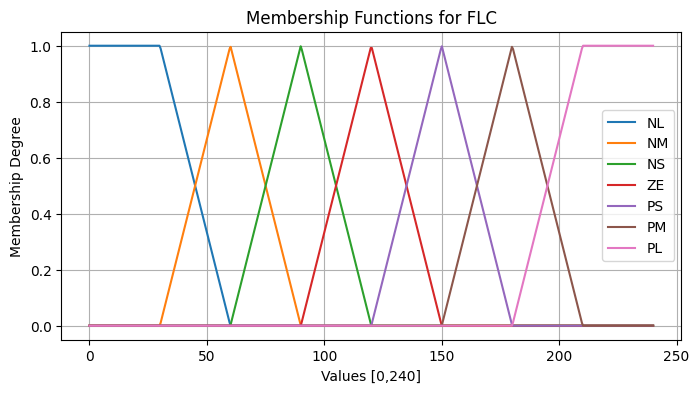

In [ ]:
# Compute fuzzy sets for entire range
def partition(x):
    return [
        openLeft(x,30,60),                     # NL
        triangular(x,30,60,90),                # NM
        triangular(x,60,90,120),               # NS
        triangular(x,90,120,150),              # ZE
        triangular(x,120,150,180),             # PS
        triangular(x,150,180,210),             # PM
        openRight(x,180,210)                   # PL
    ]
NL, NM, NS, ZE, PS, PM, PL = partition(x)

# Plot all sets
plt.figure(figsize=(8,4))
plt.plot(x, NL, label='NL')
plt.plot(x, NM, label='NM')
plt.plot(x, NS, label='NS')
plt.plot(x, ZE, label='ZE')
plt.plot(x, PS, label='PS')
plt.plot(x, PM, label='PM')
plt.plot(x, PL, label='PL')

plt.title('Membership Functions for FLC')
plt.xlabel('Values [0,240]')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

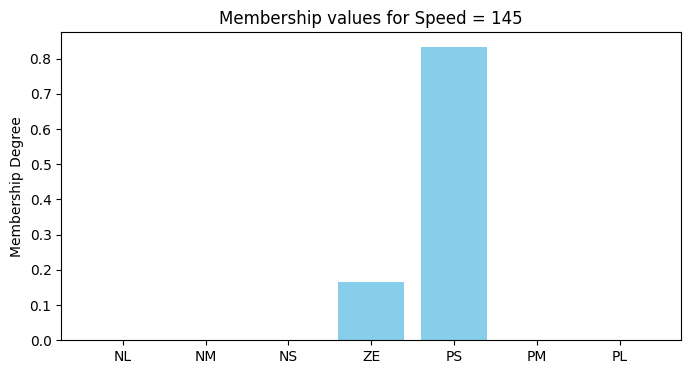

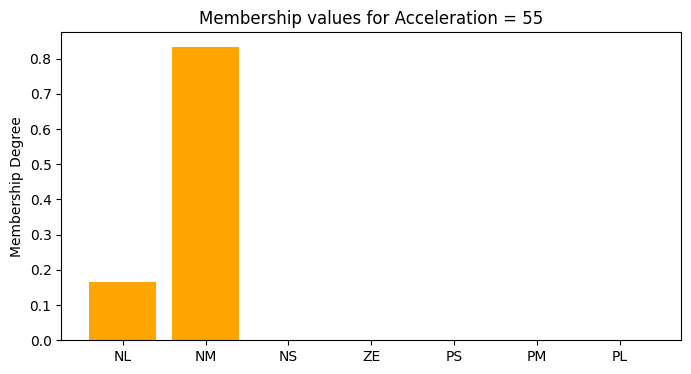

In [ ]:
# Evaluate membership values
speed_memberships = [openLeft(Speed,30,60),
                     triangular(Speed,30,60,90),
                     triangular(Speed,60,90,120),
                     triangular(Speed,90,120,150),
                     triangular(Speed,120,150,180),
                     triangular(Speed,150,180,210),
                     openRight(Speed,180,210)]

accel_memberships = [openLeft(Acceleration,30,60),
                     triangular(Acceleration,30,60,90),
                     triangular(Acceleration,60,90,120),
                     triangular(Acceleration,90,120,150),
                     triangular(Acceleration,120,150,180),
                     triangular(Acceleration,150,180,210),
                     openRight(Acceleration,180,210)]

labels = ["NL","NM","NS","ZE","PS","PM","PL"]
NLSD, NMSD, NSSD, ZESD, PSSD, PMSD, PLSD = speed_memberships
NLAC, NMAC, NSAC, ZEAC, PSAC, PMAC, PLAC = accel_memberships

plt.figure(figsize=(8,4))
plt.bar(labels, speed_memberships, color='skyblue')
plt.title(f'Membership values for Speed = {Speed}')
plt.ylabel('Membership Degree')
plt.show()

plt.figure(figsize=(8,4))
plt.bar(labels, accel_memberships, color='orange')
plt.title(f'Membership values for Acceleration = {Acceleration}')
plt.ylabel('Membership Degree')
plt.show()

Display the fuzzy values for all fuzzy sets

In [ ]:
outPut = [[NLSD,NMSD,NSSD,ZESD,PSSD,PMSD,PLSD],
          [NLAC,NMAC,NSAC,ZEAC,PSAC,PMAC,PLAC]]
print("The fuzzy values of the crisp inputs")
print(["NL","NM","NS","ZE","PS","PM","PLSD"])
print(np.round(outPut,2))

The fuzzy values of the crisp inputs
['NL', 'NM', 'NS', 'ZE', 'PS', 'PM', 'PLSD']
[[0.   0.   0.   0.17 0.83 0.   0.  ]
 [0.17 0.83 0.   0.   0.   0.   0.  ]]


Rule generation

In [ ]:
def compare(TC1, TC2):
    if TC1 > TC2 and TC1 != 0 and TC2 != 0:
        TC = TC2
    else:
        TC = TC1
    if TC1 == 0 and TC2 != 0:
        TC = TC2
    if TC2 == 0 and TC1 != 0:
        TC = TC1
    return TC

In [ ]:
def rule(NLSD,NMSD,NSSD,ZESD,PSSD,PMSD,PLSD,NLAC,NMAC,NSAC,ZEAC,PSAC,PMAC,PLAC):
    PLTC1 = min(NLSD,ZEAC)
    PLTC2 = min(ZESD,NLAC)
    PLTC = compare(PLTC1, PLTC2)

    PMTC1 = min(NMSD,ZEAC)
    PMTC2 = min(ZESD,NMAC)
    PMTC = compare(PMTC1, PMTC2)

    PSTC1 = min(NSSD,PSAC)
    PSTC2 = min(ZESD,NSAC)
    PSTC = compare(PSTC1, PSTC2)
    NSTC = min(PSSD,NSAC)
    NLTC = min(PLSD,ZEAC)

    return PLTC, PMTC, PSTC, NSTC, NLTC

# Evaluate fuzzy rules
PLTC, PMTC, PSTC, NSTC, NLTC = rule(NLSD,NMSD,NSSD,ZESD,PSSD,PMSD,PLSD,NLAC,NMAC,NSAC,ZEAC,PSAC,PMAC,PLAC)

# Show fuzzy outputs
print("\nFuzzy Rule Outputs:")
print(f"PLTC={PLTC:.2f}, PMTC={PMTC:.2f}, PSTC={PSTC:.2f}, NSTC={NSTC:.2f}, NLTC={NLTC:.2f}")


Fuzzy Rule Outputs:
PLTC=0.17, PMTC=0.17, PSTC=0.00, NSTC=0.00, NLTC=0.00


In [ ]:
import pandas as pd

# Define the fuzzy rule base
data = {
    "Rule No.": [1, 2, 3, 4, 5, 6, 7, 8],
    "Speed Difference (SD)": ["NL", "ZE", "NM", "NS", "PS", "PL", "ZE", "ZE"],
    "Acceleration (AC)": ["ZE", "NL", "ZE", "PS", "NS", "ZE", "NS", "NM"],
    "Throttle Control (TC)": ["PL", "PL", "PM", "PS", "NS", "NL", "PS", "PM"]
}

# Create DataFrame
rule_table = pd.DataFrame(data)

# Display neatly
print("\n=== Fuzzy Rule Base ===")
print(rule_table.to_string(index=False))


=== Fuzzy Rule Base ===
 Rule No. Speed Difference (SD) Acceleration (AC) Throttle Control (TC)
        1                    NL                ZE                    PL
        2                    ZE                NL                    PL
        3                    NM                ZE                    PM
        4                    NS                PS                    PS
        5                    PS                NS                    NS
        6                    PL                ZE                    NL
        7                    ZE                NS                    PS
        8                    ZE                NM                    PM


Defuzzification

In [ ]:
def reverse_triangular(mu, a, b, c):
    if mu == 0:
        return None
    x1 = a + mu * (b - a)
    x2 = c - mu * (c - b)
    return (x1 + x2) / 2

def reverse_openLeft(mu, a, b):
    if mu == 1:
        return a
    return b - mu * (b - a)

def reverse_openRight(mu, a, b):
    if mu == 1:
        return b
    return a + mu * (b - a)

In [ ]:
x = np.linspace(0, 240, 500)
x_values = []
if NLTC != 0:
    x_values.append(reverse_openLeft(NLTC, 30, 60))
if NSTC != 0:
    x_values.append(reverse_triangular(NSTC, 60, 90, 120))
if PSTC != 0:
    x_values.append(reverse_triangular(PSTC, 120, 150, 180))
if PMTC != 0:
    x_values.append(reverse_triangular(PMTC, 150, 180, 210))
if PLTC != 0:
    x_values.append(reverse_openRight(PLTC, 180, 210))
else: x_values.append(0)
x_values = [x for x in x_values if x is not None]
crispOutputFinal = np.mean(x_values)
print(f"Crisp Throttle Output (TC): {crispOutputFinal:.2f}")

Crisp Throttle Output (TC): 182.50


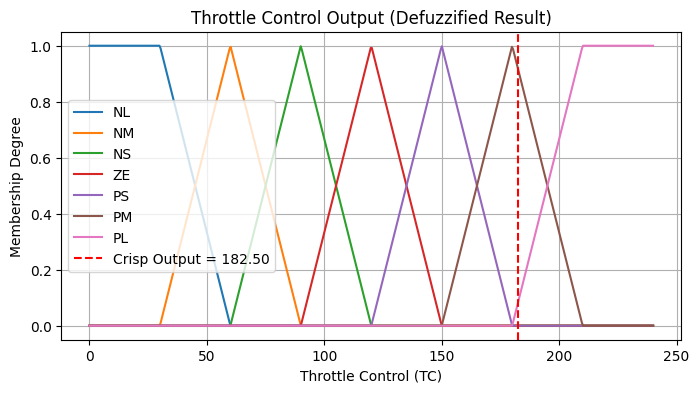

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(x, NL, label='NL')
plt.plot(x, NM, label='NM')
plt.plot(x, NS, label='NS')
plt.plot(x, ZE, label='ZE')
plt.plot(x, PS, label='PS')
plt.plot(x, PM, label='PM')
plt.plot(x, PL, label='PL')
plt.axvline(crispOutputFinal, color='red', linestyle='--', label=f'Crisp Output = {crispOutputFinal:.2f}')
plt.title('Throttle Control Output (Defuzzified Result)')
plt.xlabel('Throttle Control (TC)')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()
